# Learning from demonstration using GMM-GMR

In [23]:
import os
import pickle
from dtw import dtw
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from gmr import GMM
from gmr.utils import check_random_state

# %matplotlib notebook  # for interactive plotting

#### Generate 3D demonstrations

In [24]:
def make_3D_demonstrations(n_demonstrations: int,\
                           n_steps: int, 
                           sigma: float = 0.25,
                           mu: float = 0.5,
                           start: np.ndarray = np.zeros(3), 
                           goal: np.ndarray = np.ones(3), 
                           random_state: int = None) -> np.ndarray:
    """Generate 3D demonstrations data.

    Args:
        n_demonstrations (int): Number of demonstrations to generate.
        sigma (float, optional): Variance of the Gaussian. Defaults to 0.25.
        mu (float, optional): Mean of the Gaussian. Defaults to 0.5.
        start (np.ndarray, optional): Start position. Defaults to np.zeros(3).
        goal (np.ndarray, optional): Goal position. Defaults to np.ones(3).
        random_state (int, optional): Random seed. Defaults to None.

    Returns:
        np.ndarray: Generated demonstrations data of shape (n_demonstrations, n_steps, n_dim).
    """
    random_state = np.random.RandomState(random_state)

    X = np.empty((3, n_steps, n_demonstrations))

    # Generate ground-truth for plotting
    ground_truth = np.empty((3, n_steps))
    T = np.linspace(-0, 1, n_steps)
    ground_truth[0] = T
    ground_truth[1] = (T / 20 + 1 / (sigma * np.sqrt(2 * np.pi)) *
                       np.exp(-0.5 * ((T - mu) / sigma) ** 2))
    ground_truth[2] = (T / 20 + 1 / (sigma * np.sqrt(2 * np.pi)) *
                       np.exp(-0.5 * ((T - mu) / sigma) ** 2))

    # Generate trajectories
    for i in range(n_demonstrations):
        noisy_sigma = sigma * random_state.normal(1.0, 0.1)
        noisy_mu = mu * random_state.normal(1.0, 0.1)
        X[0, :, i] = T
        X[1, :, i] = T + (1 / (noisy_sigma * np.sqrt(2 * np.pi)) *
                          np.exp(-0.5 * ((T - noisy_mu) /
                                         noisy_sigma) ** 2))
        X[2, :, i] = T + (1 / (noisy_sigma * np.sqrt(2 * np.pi)) *
                          np.exp(-0.5 * ((T - noisy_mu) /
                                         noisy_sigma) ** 2))

    # Spatial alignment
    current_start = ground_truth[:, 0]
    current_goal = ground_truth[:, -1]
    current_amplitude = current_goal - current_start
    amplitude = goal - start
    ground_truth = ((ground_truth.T - current_start) * amplitude /
                    current_amplitude + start).T

    for demo_idx in range(n_demonstrations):
        current_start = X[:, 0, demo_idx]
        current_goal = X[:, -1, demo_idx]
        current_amplitude = current_goal - current_start
        X[:, :, demo_idx] = ((X[:, :, demo_idx].T - current_start) *
                             amplitude / current_amplitude + start).T
    
    # Transpose to (n_demonstrations, n_steps, n_dim)
    X = X.transpose(2, 1, 0)

    return X

X = make_3D_demonstrations(n_demonstrations=10, 
                              n_steps=50, 
                              goal=np.array([1., 2., 3.]),
                              random_state=0)

print(f"Generated 3D demonstrations data of shape:= {X.shape}")

Generated 3D demonstrations data of shape:= (10, 50, 3)


#### (Optional) Use recorded 3D demonstrations (via simulation/real)

In [25]:
def align_trajectories(data: list) -> np.ndarray:
    """Align trajectories using Dynamic Time Warping (DTW).

    Args:
        data (list): List of trajectories to align.

    Returns:
        np.ndarray: Aligned trajectories.
    """
   
    ls = np.argmax([d.shape[0] for d in data])

    data_warp = []

    for d in data:
        dist, cost, acc, path = dtw(data[ls], d,
                                    dist=lambda x, y: np.linalg.norm(x - y, ord=1))

        data_warp += [d[path[1]][:data[ls].shape[0]]]

    return data_warp


# Path to demonstrations
path = "data/panda_demos/"

# Create a list of demonstrations
demonstrations = []
for file in os.listdir(path):
    if file.endswith(".pickle"):
        with open(os.path.join(path, file), "rb") as f:
            demonstration = np.array(pickle.load(f))          
            demonstration = demonstration.reshape(-1, demonstration.shape[-1])
            demonstrations.append(demonstration)

# Align trajectories
# X = align_trajectories(demonstrations)
# (n_demonstrations, n_steps, n_dim)
# X = np.array(X)[:, :, :3]
# print(f"Loaded {len(X)} demonstrations of shape:= {X.shape}")

#### Plot 3D demonstrations

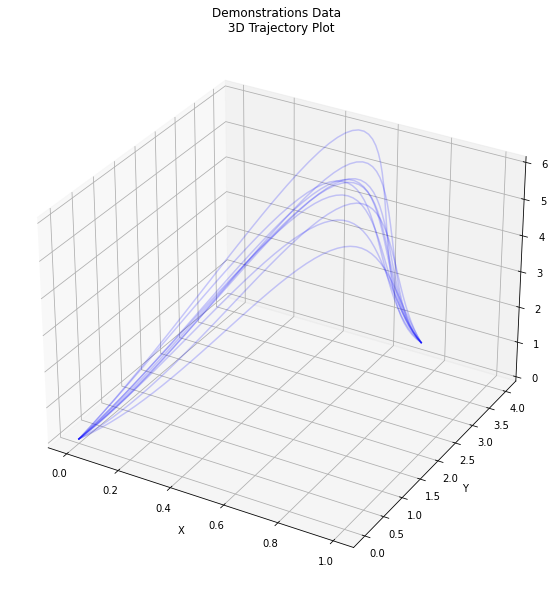

In [26]:
def plot_3D_data(data: np.ndarray, 
                 color: string = None, 
                 sampled_data: np.ndarray = None, 
                 sampled_color: string = None) -> None:
    """Plot 3D trajectories.

    Args:
        data (np.ndarray): data to plot.
        color (string, optional): color of the data plot. Defaults to None.
        sampled_data (np.ndarray, optional): sampled data to plot. Defaults to None.
        sampled_color (string, optional): color of the sampled data plot. Defaults to None.
    """
    # Create a 3D plot
    fig = plt.figure(num=1, figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get the number of steps and trajectory length
    n_steps, traj_length, n_dims = data.shape

    # Plot original demonstrations data
    for i in range(n_steps):
        ax.plot(data[i, :, 0], data[i, :, 1], data[i, :, 2], c=color, alpha=0.2)

    # Plot sampled demonstration data if provided
    if sampled_data is not None:
        n_sampled_steps, sampled_traj_length, _ = sampled_data.shape
        for i in range(n_sampled_steps):
            ax.plot(sampled_data[i, :, 0], sampled_data[i, :, 1], sampled_data[i, :, 2], c=sampled_color, alpha=0.5)

    # Additional plot settings
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Demonstrations Data \n 3D Trajectory Plot')

    plt.show()

# Plot the demonstration data
plot_3D_data(X, color='b')

#### Data Pre-processing: Adding Timestamp to the Dataset for Time-Variant Trajectories

In [27]:
n_demonstrations, n_steps, n_task_dims = X.shape
print(f"Generated 3D demonstrations data of shape:= {X.shape}")

# Add timestamp
# <t, x_t, y_t, z_t>
X_train = np.empty((n_demonstrations, n_steps, n_task_dims + 1))

X_train[:, :, 1:] = X
t = np.linspace(0, n_steps, num=n_steps, dtype=int)
X_train[:, :, 0] = t
print(f"Adding timestamp as a dimension to the generated demonstrations data:= {X_train.shape}")

# Reshape 
X_train = X_train.reshape(n_demonstrations * n_steps, n_task_dims + 1)
print(f"Dataset for training:= {X_train.shape}")

Generated 3D demonstrations data of shape:= (10, 50, 3)
Adding timestamp as a dimension to the generated demonstrations data:= (10, 50, 4)
Dataset for training:= (500, 4)


#### Training GMM

In [28]:
# Initialize variables
random_state = check_random_state(0)
n_components = 8

# Using BayesianGaussianMixture to initialize GMM
bgmm = BayesianGaussianMixture(n_components=n_components, 
                               max_iter=500).fit(X_train)

# Initialize GMM
gmm = GMM(n_components=n_components,
          priors=bgmm.weights_,
          means=bgmm.means_,
          covariances=bgmm.covariances_,
          random_state=random_state)

#### Sampled Trajectory

Sampled trajectory: (1, 50, 3)


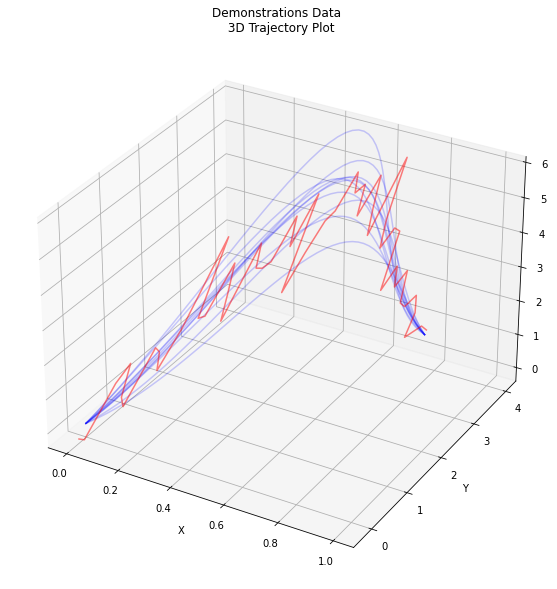

In [29]:
# Sample a trajectory
sampled_trj = []

# Indices of dimensions to condition (timestamp t is the first dimension)
indices = [0]  

# Number of steps to sample
for step in range(n_steps):
    
    # Condition on the first dimension (timestamp t)
    cgmm = gmm.condition(indices, step)
    # Sample a point from the conditional GMM with confidence region 0.7
    point = cgmm.sample_confidence_region(1, alpha=0.7)[0]
    # Append the sampled point to the trajectory
    sampled_trj.append(point)

# Reshape to (1, n_steps, n_task_dims)
sampled_trj = np.array(sampled_trj).reshape(1, n_steps, n_task_dims)
print(f"Sampled trajectory: {sampled_trj.shape}")

# Plot the demonstration data
plot_3D_data(X, 
             color='b', 
             sampled_data=sampled_trj,
             sampled_color='r')